# Análisis de comentarios de Reddit acerca de vacunas


Análisis exploratorio de datos basado en: https://www.kaggle.com/fahadmehfoooz/reddit-vaccine-myths

In [1]:
!pip install spacytextblob==0.1.7
import numpy as np 
import pandas as pd 
import os
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.style as style
import zipfile
import json
from google.colab import drive
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Utilizando la API de Kaggle para obtener el dataset

Agregar cuenta de Drive al entorno de ejecución

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Es necesario ir a la cuenta personal de Kaggle y descargar la llave de la API que se genera desde la opción "Create new API Token"

In [3]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 4.2MB 34.2MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 112kB 72.9MB/s 
     |████████████████████████████████| 143kB 67.1MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-lyy32n6f/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-lyy32n6f/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-y4kuqtd9/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
{"username":"catalinanaranjo","key":"3665abaedf46e3fee5a11e8d83872f76"}

In [4]:
!kaggle datasets download -d gpreda/reddit-vaccine-myths

  0% 0.00/229k [00:00<?, ?B/s]
100% 229k/229k [00:00<00:00, 79.5MB/s]


In [5]:
file_dezip = zipfile.ZipFile('/content/reddit-vaccine-myths.zip')
file_dezip.extractall('/content')
vaccine = pd.read_csv('/content/reddit_vm.csv')
vaccine.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28


In [7]:
print(f'The number of rows are {vaccine.shape[0] } and the number of columns are {vaccine.shape[1]}')

The number of rows are 1531 and the number of columns are 8


In [8]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1531 non-null   object 
 1   score      1531 non-null   int64  
 2   id         1531 non-null   object 
 3   url        452 non-null    object 
 4   comms_num  1531 non-null   int64  
 5   created    1531 non-null   float64
 6   body       1165 non-null   object 
 7   timestamp  1531 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 95.8+ KB


In [9]:
categorical_col, covariate_val=[],[]

for i in vaccine.columns:
    
    if vaccine[i].dtype == 'object':
        categorical_col.append(i)
    else:
        covariate_val.append(i)
        
print('The categorical features are :')
print()
for i in range(len(categorical_col)):
    print(f'{i+1}. {categorical_col[i]}')
        
print()
print('The covariate features are :')
print()
for i in range(len(covariate_val)):
    print(f'{i+1}. {covariate_val[i]}')
        
print()

The categorical features are :

1. title
2. id
3. url
4. body
5. timestamp

The covariate features are :

1. score
2. comms_num
3. created



In [10]:
vaccine.describe()

,score,comms_num,created
count,1531.000000,1531.00000,1.531000e+03
mean,3.728935,1.89484,1.543393e+09
std,30.468397,16.49908,7.029850e+07
min,-12.000000,0.00000,1.389624e+09
25%,1.000000,0.00000,1.554246e+09
50%,1.000000,0.00000,1.568874e+09
75%,3.000000,1.00000,1.581115e+09
max,1182.000000,596.00000,1.621304e+09


In [11]:
vaccine['year']=pd.DatetimeIndex(vaccine['timestamp']).year
vaccine['month']=pd.DatetimeIndex(vaccine['timestamp']).month
vaccine.head(5)

,title,score,id,url,comms_num,created,body,timestamp,year,month
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45,2021,2
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07,2021,2
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08,2021,2
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13,2021,2
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28,2021,2


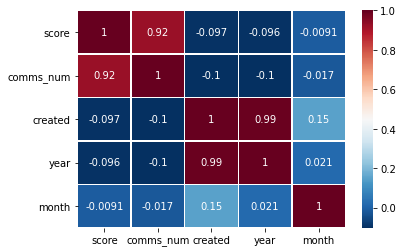

In [12]:
pearsoncorrelation = vaccine.corr(method='pearson')
sns.heatmap(pearsoncorrelation, 
            xticklabels=pearsoncorrelation.columns,
            yticklabels=pearsoncorrelation.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

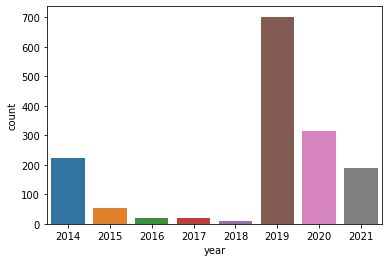

In [13]:
sns.countplot(data=vaccine,x='year')

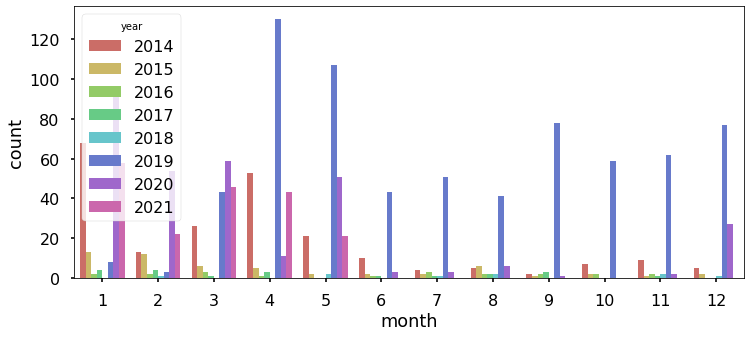

In [15]:
fig, axs = plt.subplots(1,1, figsize=(12,5))
style.use('seaborn-poster') 
sns.countplot(data=vaccine, x='month',palette = 'hls',hue='year')

5.1 Dropping Columns With High Correlation And Null Values

In [16]:
vaccine.drop(columns=['comms_num','id','url','created','timestamp'], inplace=True)
vaccine.head()

,title,score,body,year,month
0,Health Canada approves AstraZeneca COVID-19 va...,7,NaN,2021,2
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,NaN,2021,2
2,Coronavirus variants could fuel Canada's third...,6,NaN,2021,2
3,Canadian government to extend COVID-19 emergen...,1,NaN,2021,2
4,Canada: Pfizer is 'extremely committed' to mee...,6,NaN,2021,2


In [17]:
#Lowercase the text columns
vaccine['title'] = vaccine['title'].astype(str)
vaccine['body'] = vaccine['body'].astype(str)


vaccine['title'] = vaccine['title'].apply(lambda word: " ".join(word.lower() for word in word.split()))
vaccine['body'] = vaccine['body'].apply(lambda word: " ".join(word.lower() for word in word.split()))

vaccine.head()

,title,score,body,year,month
0,health canada approves astrazeneca covid-19 va...,7,nan,2021,2
1,covid-19 in canada: 'vaccination passports' a ...,2,nan,2021,2
2,coronavirus variants could fuel canada's third...,6,nan,2021,2
3,canadian government to extend covid-19 emergen...,1,nan,2021,2
4,canada: pfizer is 'extremely committed' to mee...,6,nan,2021,2


Stopwords

In [18]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = nltk.corpus.stopwords.words('english')
vaccine['title'] = vaccine['title'].apply(lambda word: " ".join(word for word in word.split() if word not in stopwords))
vaccine['body'] = vaccine['body'].apply(lambda word: " ".join(word for word in word.split() if word not in stopwords))
vaccine.head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,title,score,body,year,month
0,health canada approves astrazeneca covid-19 va...,7,nan,2021,2
1,covid-19 canada: 'vaccination passports' near ...,2,nan,2021,2
2,coronavirus variants could fuel canada's third...,6,nan,2021,2
3,canadian government extend covid-19 emergency ...,1,nan,2021,2
4,canada: pfizer 'extremely committed' meeting v...,6,nan,2021,2


In [19]:
#Calculating the Polarity and Subjectivity
spaceit = spacy.load('en_core_web_sm')
stb = SpacyTextBlob()
spaceit.add_pipe(stb)
vaccine['title_subjectivity'] = vaccine['title'].apply(lambda x: spaceit(x)._.sentiment.subjectivity)
vaccine['title_polarity'] = vaccine['title'].apply(lambda x: spaceit(x)._.sentiment.polarity)
vaccine

vaccine['body_subjectivity'] = vaccine['body'].apply(lambda x: spaceit(x)._.sentiment.subjectivity)
vaccine['body_polarity'] = vaccine['body'].apply(lambda x: spaceit(x)._.sentiment.polarity)
vaccine.head(5)

/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning:

[W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate



,title,score,body,year,month,title_subjectivity,title_polarity,body_subjectivity,body_polarity
0,health canada approves astrazeneca covid-19 va...,7,nan,2021,2,0.0,0.000,0.0,0.0
1,covid-19 canada: 'vaccination passports' near ...,2,nan,2021,2,0.4,0.100,0.0,0.0
2,coronavirus variants could fuel canada's third...,6,nan,2021,2,0.0,0.000,0.0,0.0
3,canadian government extend covid-19 emergency ...,1,nan,2021,2,0.0,0.000,0.0,0.0
4,canada: pfizer 'extremely committed' meeting v...,6,nan,2021,2,1.0,-0.125,0.0,0.0


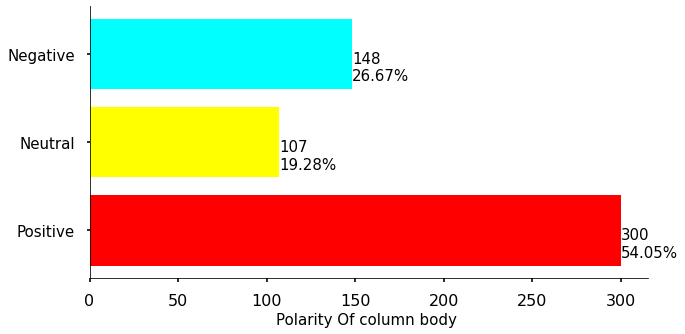

In [66]:
bp=pd.DataFrame()
bp['positive']=vaccine['body_polarity'].apply(lambda x : x if(x > 0) else None)
bp['negative']=vaccine['body_polarity'].apply(lambda x:  x if(x<=-0.05) else None)
bp['neutral']=vaccine['body_polarity'].apply(lambda x: x if(x>-0.05 and x<=.05) else None)
bp

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax = fig.add_subplot(111)


counts = [len((bp['positive']).value_counts()),len(bp['neutral'].value_counts()),len((bp['negative']).value_counts())]

percents = [100*x/sum(counts) for x in counts]

y_ax = ('Positive','Neutral','Negative')
y_tick = np.arange(len(y_ax))

ax.barh(range(len(counts)), counts, align = "center", color = ['Red', 'yellow', 'cyan'])
ax.set_yticks(y_tick)
ax.set_yticklabels(y_ax, size = 15)
ax.set_facecolor('xkcd:white')
plt.xlabel('Polarity Of column body ', size=15)



for i, y in enumerate(ax.patches):
    label_per = percents[i]
    ax.text(y.get_width()+.09, y.get_y()+.3, str(round((y.get_width()), 1)), fontsize=15)
    
    ax.text(y.get_width()+.09, y.get_y()+.1, str(f'{round((label_per), 2)}%'), fontsize=15)

sns.despine()
plt.show();

In [67]:
vaccine['Body_Sentiment_Value']=vaccine['body_polarity'].apply(lambda x : 'Neutral' if(x>-0.05 and x<=.05) else ('Negative' if(x<=-0.05) else 'Positive'))


fig = px.scatter(vaccine, x="body_polarity", y="body_subjectivity", color="Body_Sentiment_Value",)
fig.update_layout(legend = dict(bgcolor = 'pink'))
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [1]:
tp=pd.DataFrame()
tp['positive']=vaccine['title_polarity'].apply(lambda x : x if(x > 0.05) else None)
tp['negative']=vaccine['title_polarity'].apply(lambda x:  x if(x<=-0.05) else None)
tp['neutral']=vaccine['title_polarity'].apply(lambda x: x if(x>-0.05 and x<=.05) else None)
tp

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax = fig.add_subplot(111)

counts = [len((tp['positive']).value_counts()),len(tp['neutral'].value_counts()),len((tp['negative']).value_counts())]

percents = [100*x/sum(counts) for x in counts]

y_ax = ('Positive','Neutral','Negative')
y_tick = np.arange(len(y_ax))

ax.barh(range(len(counts)), counts, align = "center", color = ['red', 'black', 'orange'])
ax.set_yticks(y_tick)
ax.set_yticklabels(y_ax, size = 15)
ax.set_facecolor('xkcd:white')

plt.xlabel('Polarity Of column title ', size=15)

fig, axs = plt.subplots(1,1, figsize=(12,5))

for i, y in enumerate(ax.patches):
    label_per = percents[i]
    ax.text(y.get_width()+.09, y.get_y()+.3, str(round((y.get_width()), 1)), fontsize=15)
    
    ax.text(y.get_width()+.09, y.get_y()+.1, str(f'{round((label_per), 2)}%'), fontsize=15)

sns.despine()
plt.show()

NameError: ignored

In [69]:
vaccine['Title_Sentiment_Value']=vaccine['title_polarity'].apply(lambda x : 'Neutral' if(x>-0.05 and x<=.05) else ('Negative' if(x<=-0.05) else 'Positive'))


fig = px.scatter(vaccine, x="title_polarity", y="title_subjectivity", color="Title_Sentiment_Value",)
fig.update_layout(legend = dict(bgcolor = 'yellow'))
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

Clasificadores

In [ ]:
x = matriz_titulos.toarray()
y = is_sarc

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)